In [1]:
pip install PyMuPDF

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Pdf_3.pdf to Pdf_3 (2).pdf


In [3]:
import fitz  # PyMuPDF
import os

# Path to the PDF file you want to convert
pdf_file = '/content/Pdf_3.pdf'

# Specify the output directory where the images will be saved
output_dir = '/content/output_directory/'  # Note the /content/ prefix

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Set the resolution (increase the values for higher resolution)
xres, yres = 600, 600  # You can adjust these values

# Open the PDF file
pdf_document = fitz.open(pdf_file)

# Iterate through each page in the PDF
for page_number in range(len(pdf_document)):
    page = pdf_document.load_page(page_number)
    image = page.get_pixmap(matrix=fitz.Matrix(xres/72, yres/72))
    image.save(os.path.join(output_dir, f'page_{page_number + 1}.png'))

# Close the PDF file
pdf_document.close()


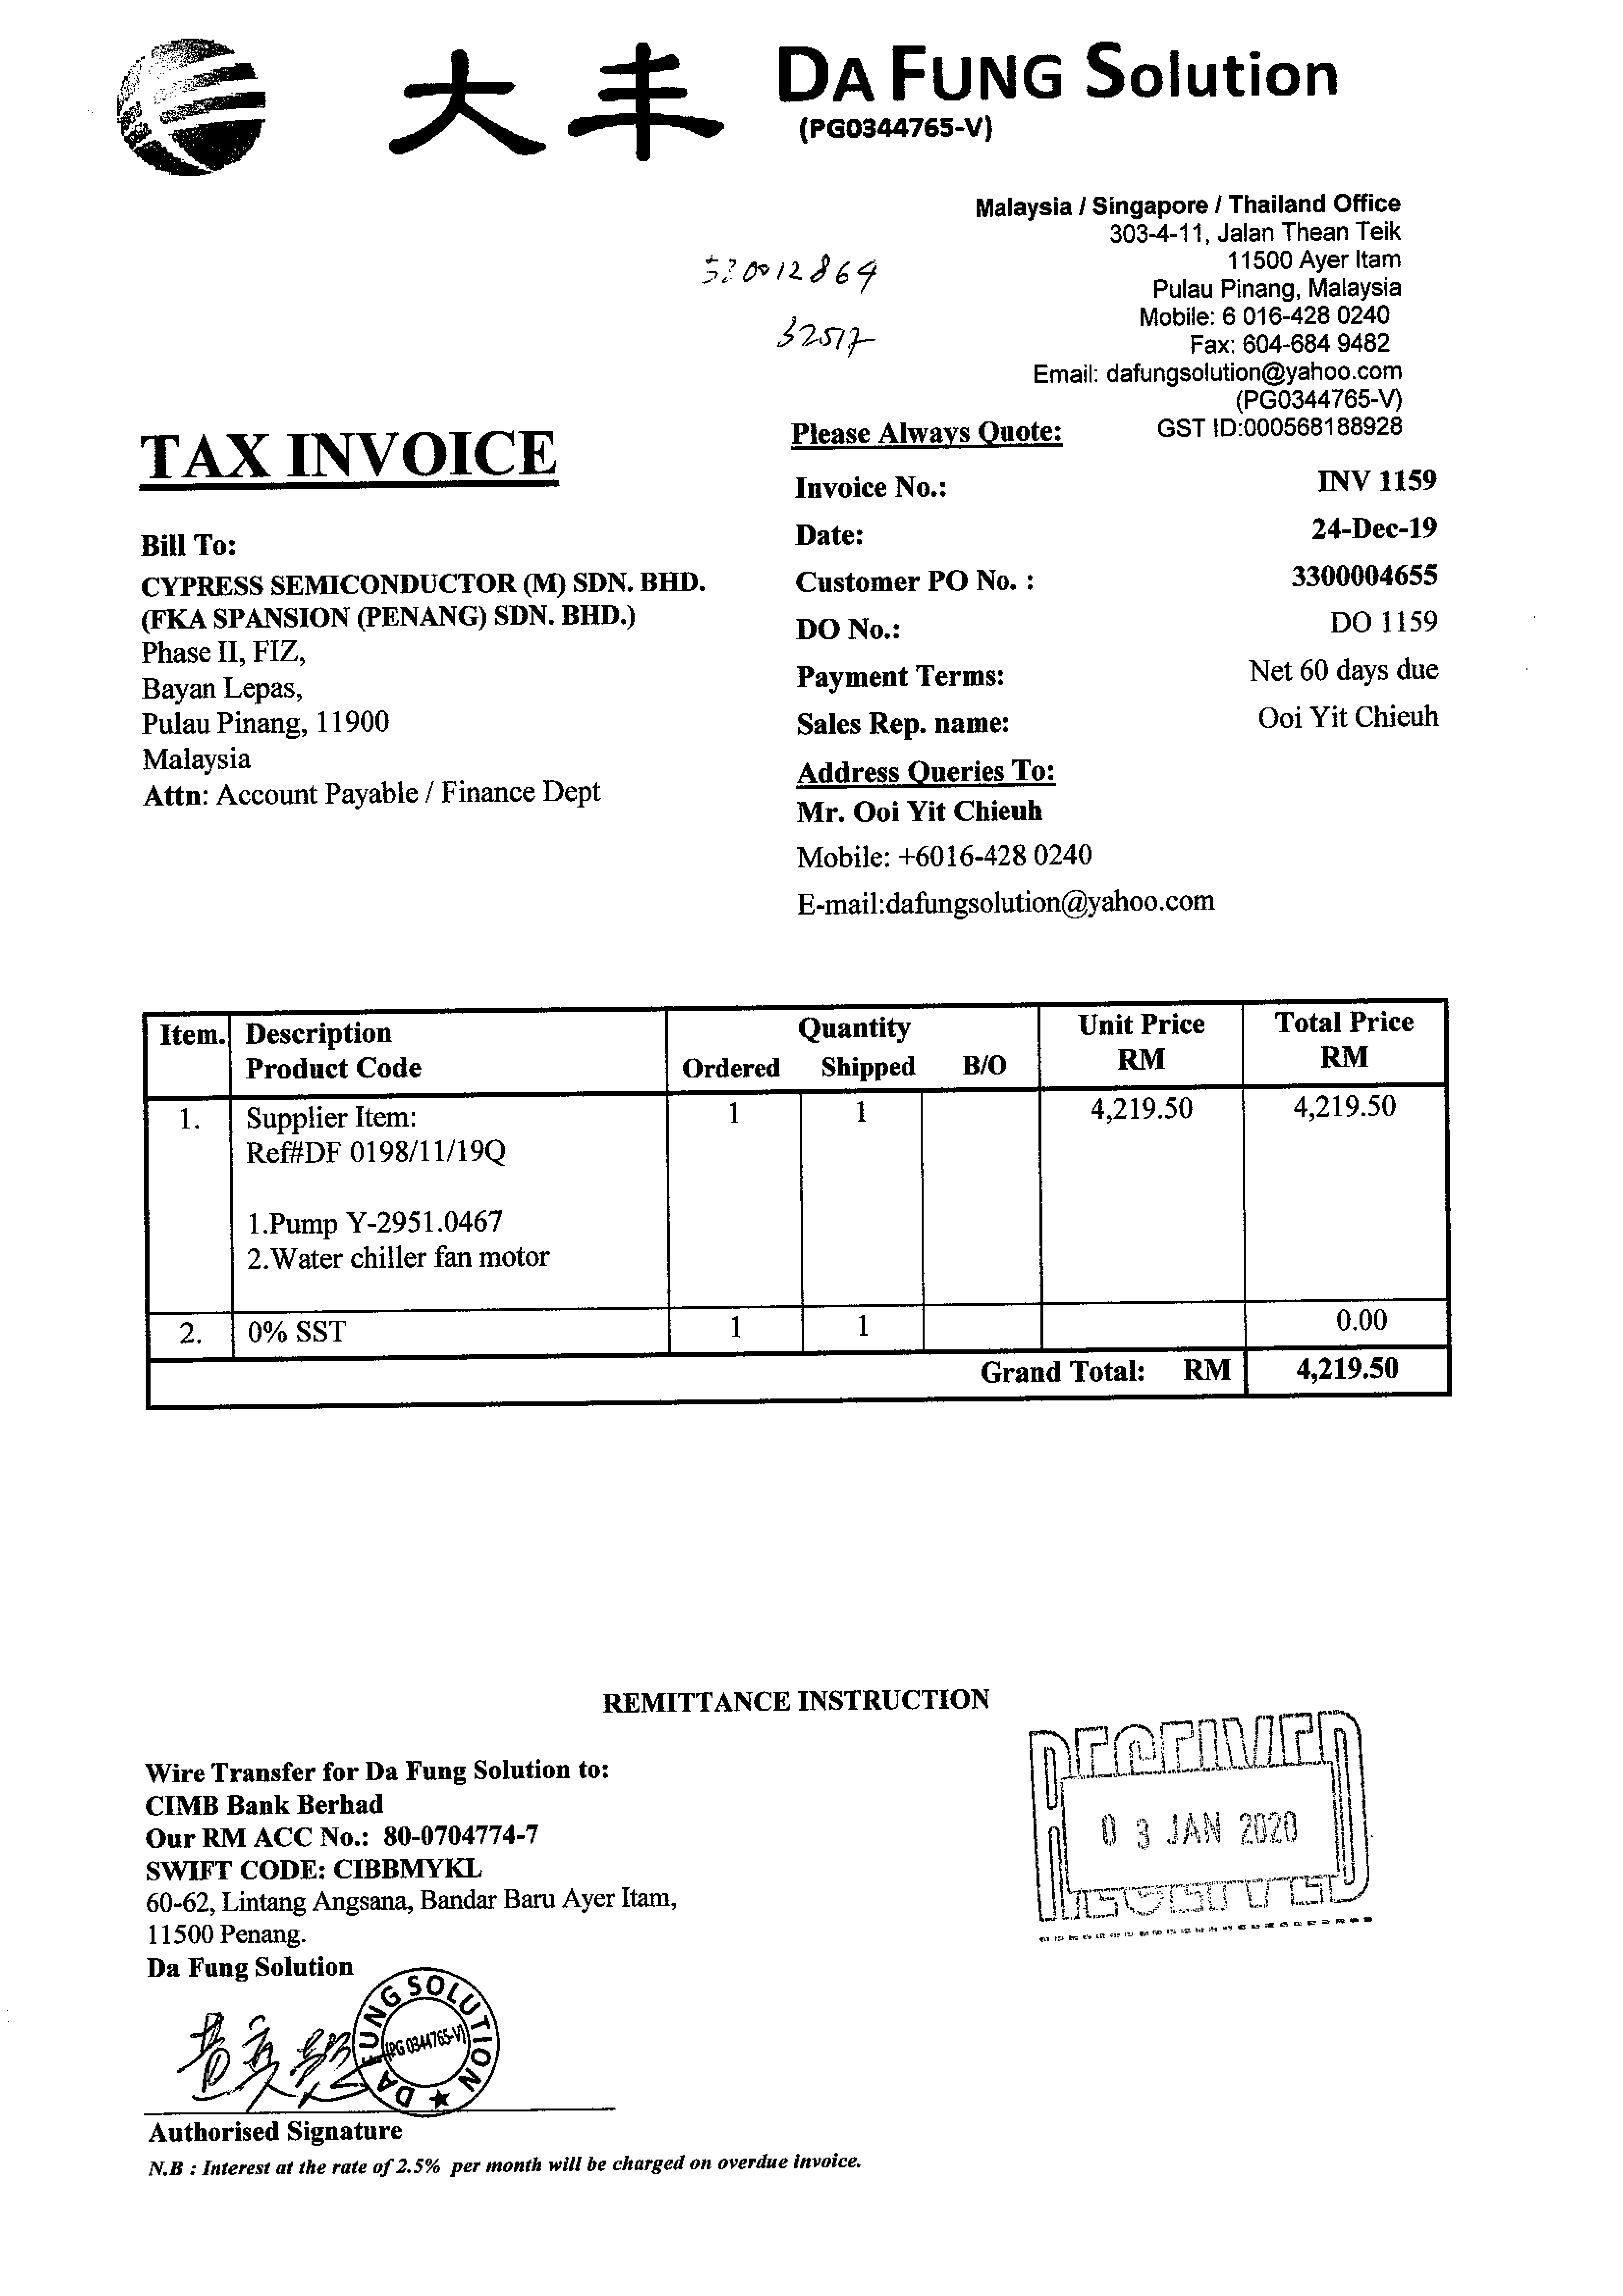

In [4]:
import cv2
from google.colab.patches import cv2_imshow
image=cv2.imread('/content/output_directory/page_1.png')
cv2_imshow(image)

In [5]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Your class definition goes here
class ImageProcessor:
    def __init__(self, image_path):
        self.image = cv2.imread(image_path)
        self.grayscale_image = None
        self.thresholded_image = None
        self.inverted_image = None
        self.dilated_image = None
        self.contours = None


    def convert_image_to_grayscale(self):
        self.grayscale_image = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)

    def threshold_image(self):
        self.thresholded_image = cv2.threshold(self.grayscale_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    def invert_image(self):
        self.inverted_image = cv2.bitwise_not(self.thresholded_image)

    def dilate_image(self):
        self.dilated_image = cv2.dilate(self.inverted_image, None, iterations=5)

    def find_contours(self):
        self.contours, self.hierarchy = cv2.findContours(self.dilated_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        # Below lines are added to show all contours
        # This is not needed, but it is useful for debugging
        self.image_with_all_contours = self.image.copy()
        cv2.drawContours(self.image_with_all_contours, self.contours, -1, (0, 255, 0), 3)

    def filter_contours_and_leave_only_rectangles(self):
        self.rectangular_contours = []
        for contour in self.contours:
            peri = cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, 0.02 * peri, True)
            if len(approx) == 4:
                self.rectangular_contours.append(approx)
        # Below lines are added to show all rectangular contours
        # This is not needed, but it is useful for debugging
        self.image_with_only_rectangular_contours = self.image.copy()
        cv2.drawContours(self.image_with_only_rectangular_contours, self.rectangular_contours, -1, (0, 255, 0), 3)
        return self.image_with_only_rectangular_contours

    def find_largest_contour_by_area(self):
        max_area = 0
        self.contour_with_max_area = None
        for contour in self.rectangular_contours:
            area = cv2.contourArea(contour)
            if area > max_area:
                max_area = area
                self.contour_with_max_area = contour
        # Below lines are added to show the contour with max area
        # This is not needed, but it is useful for debugging
        self.image_with_contour_with_max_area = self.image.copy()
        cv2.drawContours(self.image_with_contour_with_max_area, [self.contour_with_max_area], -1, (0, 255, 0), 3)

    def order_points_in_the_contour_with_max_area(self):
        self.contour_with_max_area_ordered = self.order_points(self.contour_with_max_area)
        # The code below is to plot the points on the image
        # it is not required for the perspective transform
        # it will help you to understand and debug the code
        self.image_with_points_plotted = self.image.copy()
        for point in self.contour_with_max_area_ordered:
            point_coordinates = (int(point[0]), int(point[1]))
            self.image_with_points_plotted = cv2.circle(self.image_with_points_plotted, point_coordinates, 10, (0, 0, 255), -1)

    def calculate_new_width_and_height_of_image(self):
        existing_image_width = self.image.shape[1]
        existing_image_width_reduced_by_10_percent = int(existing_image_width * 0.9)

        distance_between_top_left_and_top_right = self.calculateDistanceBetween2Points(self.contour_with_max_area_ordered[0], self.contour_with_max_area_ordered[1])
        distance_between_top_left_and_bottom_left = self.calculateDistanceBetween2Points(self.contour_with_max_area_ordered[0], self.contour_with_max_area_ordered[3])
        aspect_ratio = distance_between_top_left_and_bottom_left / distance_between_top_left_and_top_right
        self.new_image_width = existing_image_width_reduced_by_10_percent
        self.new_image_height = int(self.new_image_width * aspect_ratio)

    def apply_perspective_transform(self):
        pts1 = np.float32(self.contour_with_max_area_ordered)
        pts2 = np.float32([[0, 0], [self.new_image_width, 0], [self.new_image_width, self.new_image_height], [0, self.new_image_height]])
        matrix = cv2.getPerspectiveTransform(pts1, pts2)
        self.perspective_corrected_image = cv2.warpPerspective(self.image, matrix, (self.new_image_width, self.new_image_height))

    def calculateDistanceBetween2Points(self, p1, p2):
        dis = ((p2[0] - p1[0]) ** 2 + (p2[1] - p1[1]) ** 2) ** 0.5
        return dis

    def order_points(self, pts):
        pts = pts.reshape(4, 2)
        rect = np.zeros((4, 2), dtype="float32")
        s = pts.sum(axis=1)
        rect[0] = pts[np.argmin(s)]
        rect[2] = pts[np.argmax(s)]
        diff = np.diff(pts, axis=1)
        rect[1] = pts[np.argmin(diff)]
        rect[3] = pts[np.argmax(diff)]
        return rect

    def add_10_percent_padding(self):
        image_height = self.perspective_corrected_image.shape[0]
        padding = int(image_height * 0.1)
        self.perspective_corrected_image_with_padding = cv2.copyMakeBorder(self.perspective_corrected_image, padding, padding, padding, padding, cv2.BORDER_CONSTANT, value=[255, 255, 255])
        # Apply additional processing to the padded image

    def save_perspective_corrected_image(self, output_path):
        cv2.imwrite(output_path, self.perspective_corrected_image_with_padding)

# Create an instance of ImageProcessor
image_processor = ImageProcessor('/content/output_directory/page_1.png')

# Process the image and find contours
image_processor.convert_image_to_grayscale()
image_processor.threshold_image()
image_processor.invert_image()
image_processor.dilate_image()
image_processor.find_contours()
image_processor.filter_contours_and_leave_only_rectangles()
image_processor.find_largest_contour_by_area()
image_processor.order_points_in_the_contour_with_max_area()
image_processor.calculate_new_width_and_height_of_image()
image_processor.apply_perspective_transform()
image_processor.add_10_percent_padding()



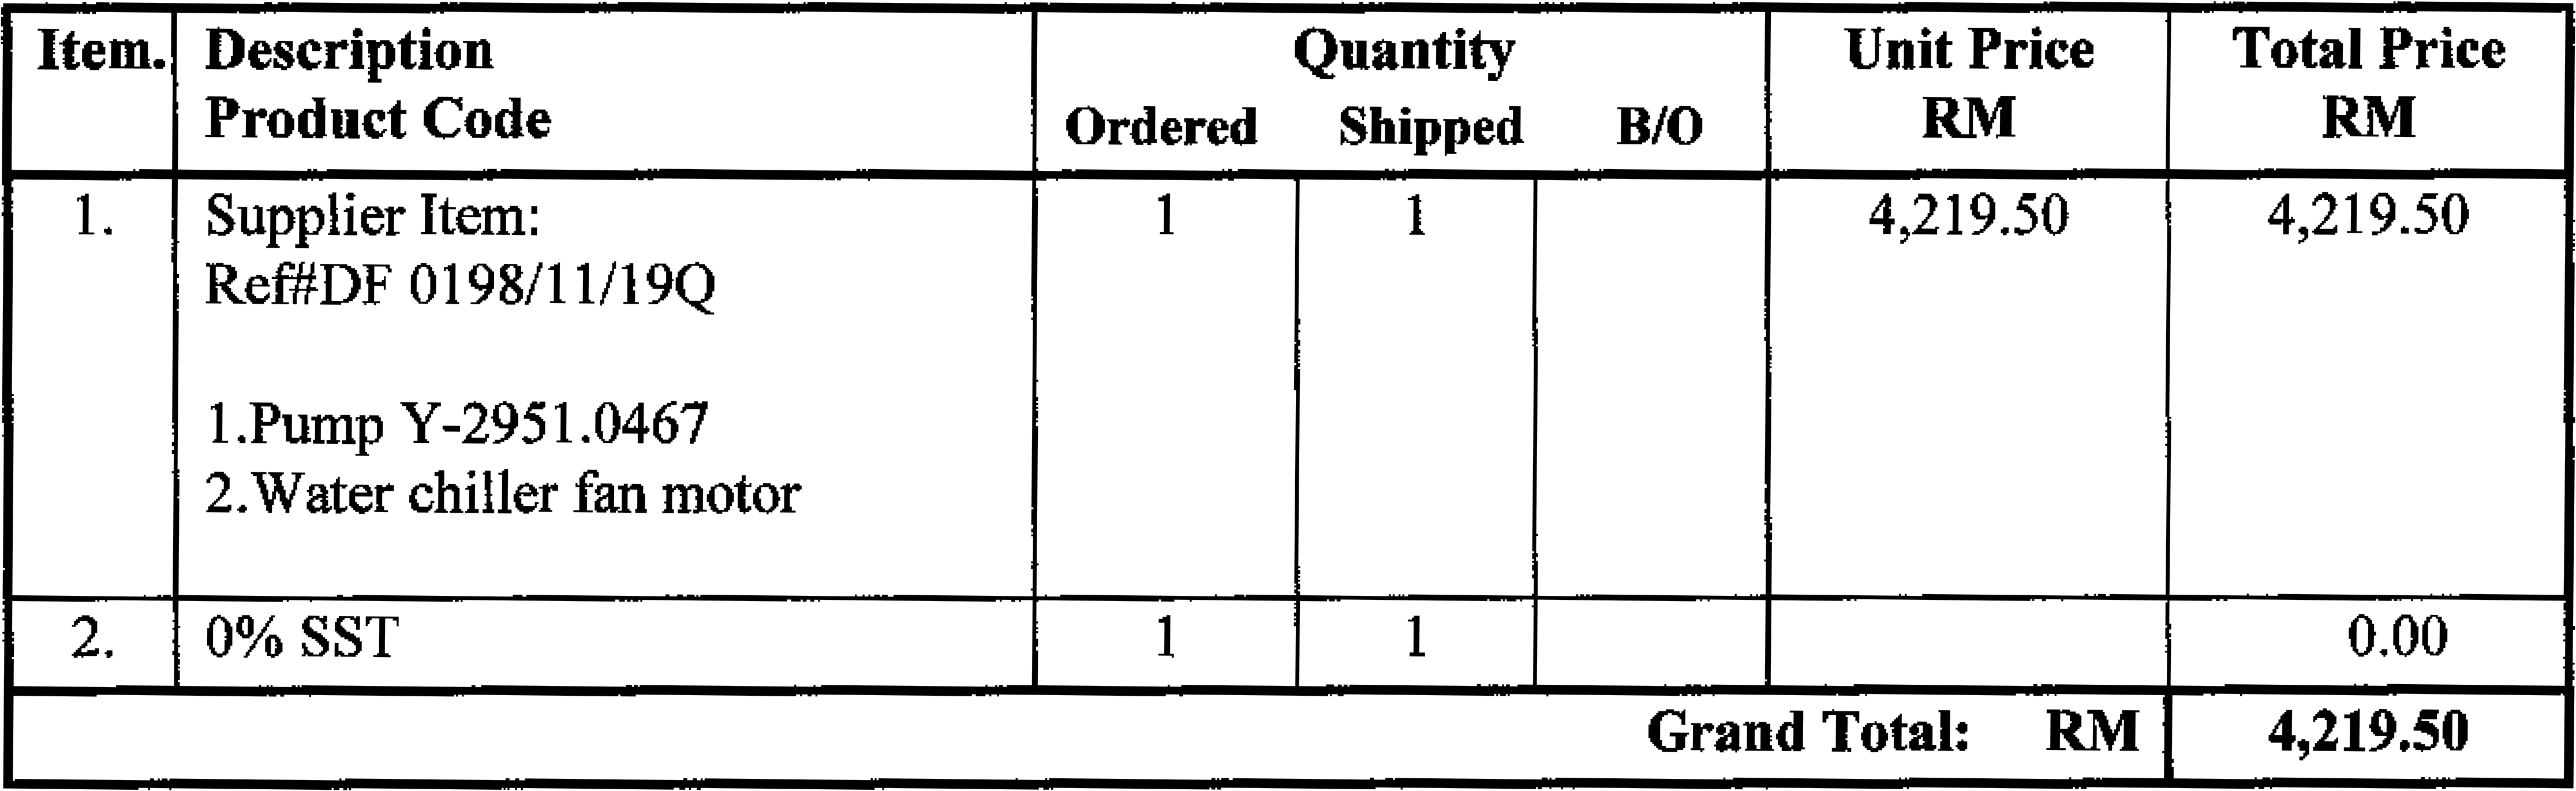

-1

In [6]:
cv2_imshow( image_processor.perspective_corrected_image)
cv2.waitKey(0)

In [7]:
output_file = '/content/output_directory/First iteration Pdf_2.png'
image_processor.save_perspective_corrected_image(output_file)

In [8]:
!apt-get install tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.


In [9]:
!pip install pytesseract

In [10]:
import cv2
import numpy as np
import pytesseract
from google.colab.patches import cv2_imshow

# Load the image using OpenCV
image = cv2.imread('/content/output_directory/First iteration Pdf_2.png')  # Update the path to your image

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur
blur = cv2.GaussianBlur(gray, (5, 5), 0)

# Thresholding
ret, threshold = cv2.threshold(blur, 150, 255, cv2.THRESH_BINARY)

# Perform OCR using Tesseract
text = pytesseract.image_to_string(threshold, lang='eng')
# Print the extracted text
print(text)


 
 

Description Quantity ae Price Total ie
Product Code Ordered =

1. | Supplier Item: 4,219.50 4,219.50
Ref#DF 0198/11/19Q
1.Pump Y-2951.0467
2.Water chiller fan motor

2 jo~ssT 0
Grand Total: RM | 4,219.50 |

     
    
  

 

 



In [11]:
import cv2
import pytesseract
import re
import pandas as pd

# Load the image using OpenCV
image = cv2.imread('/content/output_directory/First iteration Pdf_2.png')  # Update the path to your image

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur
blur = cv2.GaussianBlur(gray, (5, 5), 0)

# Thresholding
ret, threshold = cv2.threshold(blur, 150, 255, cv2.THRESH_BINARY)

# Perform OCR using Tesseract
text = pytesseract.image_to_string(threshold, lang='eng')

# Combine text lines into a single string
text = text.replace('\n', ' ')

# Extract Description
description_match = re.search(r'Description (.*?)\d+\.\s*\|', text)
if description_match:
    description = description_match.group(1).strip()
else:
    description = "Description not found"

# Extract Unit Price
unit_price_match = re.search(r'\| ([\d,]+\.\d+) \|', text)
if unit_price_match:
    unit_price = unit_price_match.group(1)
else:
    unit_price = "Unit Price not found"

# Extract Total Price
total_price_match = re.search(r'Grand Total: RM \| ([\d,]+\.\d+) \|', text)
if total_price_match:
    total_price = total_price_match.group(1)
else:
    total_price = "Total Price not found"

# Print the extracted information
#print("Description:", description)
#print("Unit Price:", unit_price)
#print("Total Price:", total_price)
data={"Description":[description],
      "Unit Price":[unit_price],
      "Total Price":[total_price]}
df=pd.DataFrame(data)
print(df)


                                         Description Unit Price Total Price
0  Quantity ae Price Total ie Product Code Ordered =   4,219.50    4,219.50
